# Kalman filtering

This tutorial is a gentle introduction to Kalman filtering.

Kalman filter (KF) is a powerful algorithm to estimate unknown values of state variables, given (noisy) observations and a physical model describing the evolution of state variables.

In general, the states are the variables we are intersted in and we want to estimate. They can be time-varying (e.g. position, speed of a car, and in general all kinematic variables) or constant parameter (e.g. weight of a car). Note that all estimated parameters will be varying in the KF (the former will vary as the quantity they try to estimate is varying, the latter will vary because we have a more and more accurate approximation of the unknown quantity they try to estimate). To run KF, we need a dynamic model describing how parameters at time $t$ should nominally evolve to the next epoch $t+1$ (here 'nominally' means, in the absence of noise, and under the assumption that the underlying physical model is exact).

On the other hand, observations will be supplied to KF in order to make up for the approximations of the dynamic model. Those observations need not be directly on the state variables. For example, we may want to estimate the 2D position of a vehicle (two state variables $x$ and $y$) and use observations based on a set of ranging beacons. But, at least, we need to provide the observation model, that tells KF how observations would be generated from state variables (simply put: if we had perfect knowledge of the state variables, how would we compute the observation values).

To sum up, KF is efficient in all situations where:

1. We want to estimate unknown states of a system.
2. We have a set of observations, coming from various sensors, providing noisy and partial information on state variables, with a good knowledge of their respective accuracies.
3. We have a prior approximate physical model on how the system should evolve under perfect conditions, and we know to what extent this approximation is correct.

In Tracklib, state and observations are stored as analytical features (AF) in the tracks, and estimation is performed recursively at each timestamp (i.e. for each point in the track). As long as the KF parameters are not intentionnaly modified, the estimation will be performed in the exact same way on different tracks (output estimated values will of course depend on each individual track observations).

Running a KF with $n$ states and $m$ observation variables requires 6 inputs:

1. A dynamic model $F$ (an equation describing how the $n$ state variables are nominally evolving to the next time step).
2. A covariance matrix $Q$ describing how $F$ is a close approximation of the actual behavior of the system. The higher the values of $Q$, the less confidence we have in our model.
3. An observation model $H$ describing how the $n$ state variables are used to compute the $m$ observation variables.
4. A covariance matrix $R$ describing how $H$ is a close approximation of the actual behavior of the sensors. The higher the values of $R$, the less confidence we have in our observations.
5. An intial estimate $X_0$ of the state parameters.
6. A covariance matrix $P_0$ describing the confidence we have in this initial estimate $X_0$.

If we have no information about the initial state (blind initialization of the filter), we can set arbitrary values in $X_0$ and  set $P_0$ to be a diagonal matrix with arbitrarily large variances. 

Note that $Q$ and $R$ values are somehow apportionned to each other. Increasing values of $Q$ (i.e. decreasing our confidence in the dynamic model) is equivalent to decreasing the values of $R$ (hence increasing the confience we have in our observations).

Note also that the physical relation $H$ between state and observations needs not be invertible. This means that we are not assuming that the perfect state of the system can be retrieved solely from the observations at any given epoch. However, if the relation $H$ is only poorly informative, then we would better have a strong and constraining model $F$ to avoid divergence of the solution. On the opposite, a sloppy and non-informative dynamic model should always be paired with invertible or nearly invertible observation model. 

In vanilla KF, the relations $F$ and $H$ must be linear, and are then described by matrices ($n \times n$ matrix for $F$, with $n \times n$ covariance matrix $Q$ and $m \times n$ matrix for $H$ with $m \times m$ covariance matrix $R$). However, Tracklib implements an Unscented Kalman Filter (UKF) which can be used to cover also the cases where $F$ and $H$ are non-linear. In this case they would be described as $\mathbb{R}^n \rightarrow \mathbb{R}^n$ and $\mathbb{R}^n \rightarrow \mathbb{R}^m$ functions for $F$ and $H$, respectively. In this case covariances $Q$ and $R$ still remain in matrix form.

Let's start to implement a KF in Tracklib.


## First we set our environment

In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import os.path
import sys

#-------------------------------------------------------
# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In this example, we will generate a synthetic smooth track, add some noise to it, and then try to retrieve the original track. To generate a track we use the function generate from the package Synthetics. The parameter 0.2 describes the smoothness of the track; here we set not to low value, to get smooth and easily predictable kinematics. The parameter dt=10 is the timestamp increment. In order to get reproducible results, we use the seed 123.

In [2]:
import tracklib.algo.Stochastics as Stochastics
import tracklib.algo.Synthetics as Synthetics

Stochastics.seed(123)
track1 = Synthetics.generate(0.2, dt=10)
track2 = track1.noise(1)

Generating track from 27/01/1970 07:59:33 to 27/01/1970 08:59:33


Let's inspect the generated tracks

-------------------------------------
GPS track #0 of user 0:
-------------------------------------
  Nb of pt(s):   360
  Ref sys id   : ENU
  Starting at  : 27/01/1970 07:59:43
  Ending at    : 27/01/1970 08:59:33
  Duration     : 3590.000 s
  Length       : 159.242 m
-------------------------------------
Analytical feature(s):
 - abs_curv
-------------------------------------



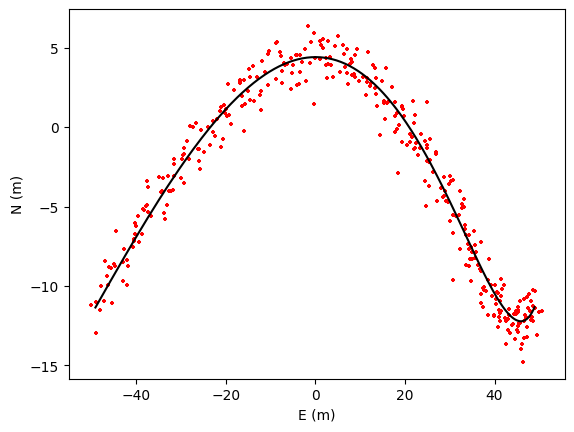

In [3]:
track1.summary()
track1.plot('k-')
track2.plot('r+')
plt.show()